In [1]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

In [2]:
class PolicyNet(Model):  # 정책 신경망
    def __init__(self, action_size=2):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = F.softmax(x)  # 확률 출력
        return x

In [3]:
class ValueNet(Model):  # 가치 함수 신경망
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [4]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v = 0.0005
        self.action_size = 2

        self.pi = PolicyNet()
        self.v = ValueNet()
        self.optimizer_pi = optimizers.Adam(self.lr_pi).setup(self.pi)
        self.optimizer_v = optimizers.Adam(self.lr_v).setup(self.v)

    def get_action(self, state):
        state = state[np.newaxis, :]  # 배치 처리용 축 추가
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]  # 선택된 행동과 해당 행동의 확률 반환

    def update(self, state, action_prob, reward, next_state, done):
        # 배치 처리용 축 추가
        state = state[np.newaxis, :]
        next_state = next_state[np.newaxis, :]

        # 가치 함수(self.v)의 손실 계산
        target = reward + self.gamma * self.v(next_state) * (1 - done)  # TD 목표
        target.unchain()
        v = self.v(state)  # 현재 상태의 가치 함수
        loss_v = F.mean_squared_error(v, target)  # 두 값의 평균 제곱 오차

        # 정책(self.pi)의 손실 계산
        delta = target - v
        delta.unchain()
        loss_pi = -F.log(action_prob) * delta

        # 신경망 학습
        self.v.cleargrads()
        self.pi.cleargrads()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.update()
        self.optimizer_pi.update()

In [6]:
episodes = 3000
env = gym.make('CartPole-v0', render_mode='rgb_array')
agent = Agent()
reward_history = []


In [7]:
for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        agent.update(state, prob, reward, next_state, done)

        state = next_state
        total_reward += reward

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))


C:\Users\ljy25\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode :0, total reward : 16.0
episode :100, total reward : 9.0
episode :200, total reward : 12.0
episode :300, total reward : 13.0
episode :400, total reward : 51.0
episode :500, total reward : 47.0
episode :600, total reward : 200.0
episode :700, total reward : 156.0
episode :800, total reward : 200.0
episode :900, total reward : 142.0
episode :1000, total reward : 200.0
episode :1100, total reward : 200.0
episode :1200, total reward : 200.0
episode :1300, total reward : 200.0
episode :1400, total reward : 200.0
episode :1500, total reward : 200.0
episode :1600, total reward : 200.0
episode :1700, total reward : 200.0
episode :1800, total reward : 200.0
episode :1900, total reward : 200.0
episode :2000, total reward : 200.0
episode :2100, total reward : 170.0
episode :2200, total reward : 200.0
episode :2300, total reward : 198.0
episode :2400, total reward : 200.0
episode :2500, total reward : 200.0
episode :2600, total reward : 30.0
episode :2700, total reward : 200.0
episode :280

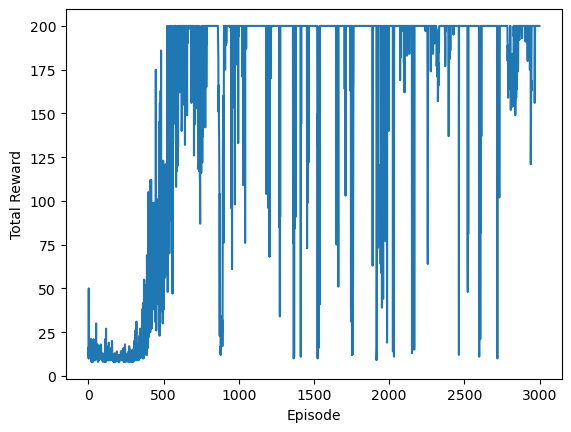

In [10]:
# [그림 9-11]의 왼쪽 그래프
from utils import plot_total_reward
plot_total_reward(reward_history)